Replaced by "SONG-fast-cov.ipynb".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


from NEID_solar_functions import *
from GP_kernels import *


#### Import SONG RVs

In [2]:
SONG = np.loadtxt('sun_SONG_full_lowess_filtered_final_used.dat')
bjd = SONG[:,0]
rv = SONG[:,1]

#### Time series

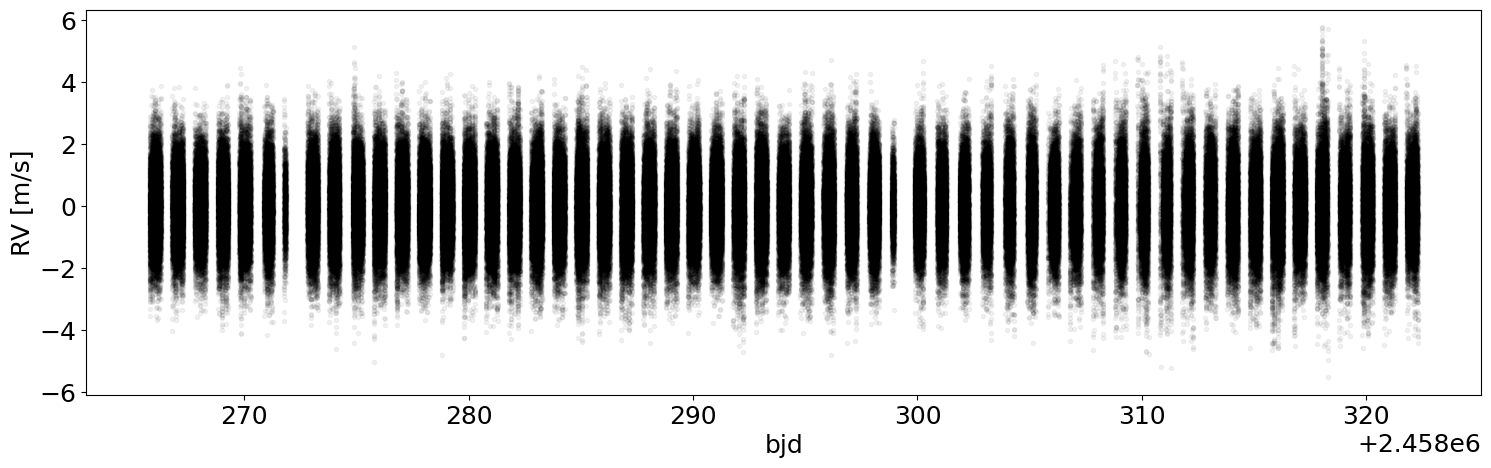

In [3]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(18, 5))
plt.xlabel('bjd')
plt.ylabel('RV [m/s]')
plt.plot(bjd, rv, 'k.', alpha=0.05)

In [4]:
pyasl.daycnv(min(bjd)), pyasl.daycnv(max(bjd))

([2018, 5, 27, 6.777839999645948], [2018, 7, 22, 19.03991999477148])

#### Time series by day (not plotted)

In [11]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 7, 22)
# end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    
    fig = plt.figure(figsize=(12, 6))
    plt.title(str(date)[:10])
    plt.plot(t, y, 'k.', alpha=0.3)
    plt.xlim([-10, 760])
    plt.ylim([-5, 5])
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV [m/s]')
    plt.savefig('./Figure/Daily_RV/RV_' + str(date)[:10] + '.png', dpi=500)
    plt.close()

#### Generate a video

In [12]:
import cv2
import glob

img_array = []
for filename in glob.glob('./Figure/Daily_RV/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video/Daily_RV.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [13]:
img.shape

(3000, 6000, 3)

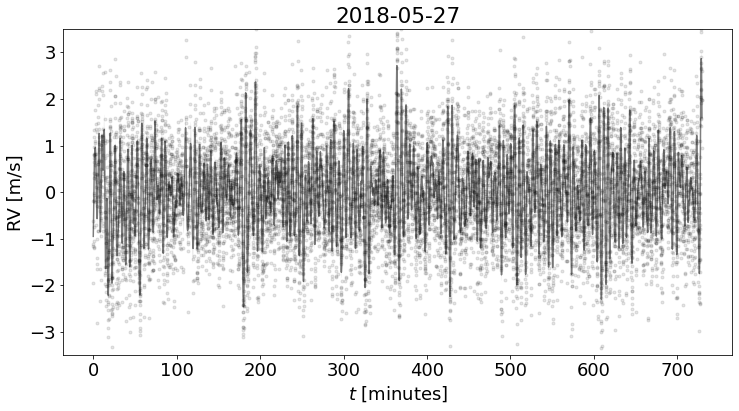

In [82]:
start_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 7, 22)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.5
    
    gp = GP_fit_p1(t, y, yerr, p=5.37)
    
    
    fig = plt.figure(figsize=(12, 6))
    plt.title(str(date)[:10])
    # plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(t, y, 'k.', alpha=0.1)
    x = np.linspace(min(t), max(t), 3000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)        
    plt.plot(x, pred_mean, color='k', alpha=0.5)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                     edgecolor="none")
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV [m/s]')

    
    # plt.xlim([0, 160])
    # plt.xlim([-10, 760])
    plt.ylim([-3.5, 3.5])
    # plt.xlabel('$t$ [minutes]')
    # plt.ylabel('RV [m/s]')
    # plt.savefig('./SONG/GP_RV_' + str(date)[:10] + '.png', dpi=600)
    plt.show()
    

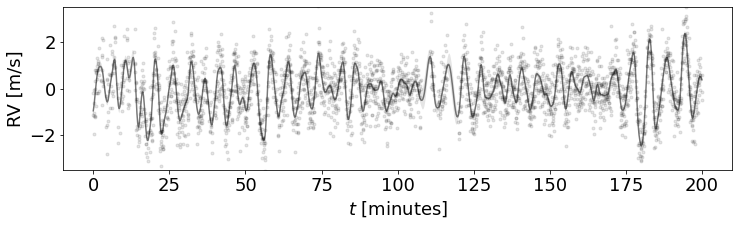

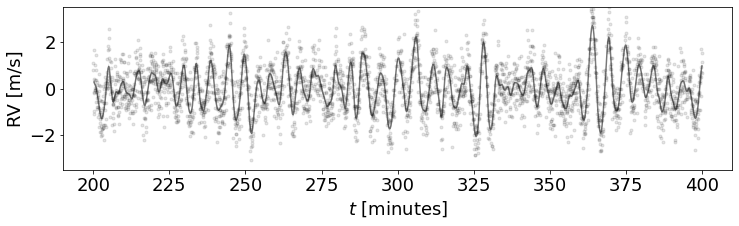

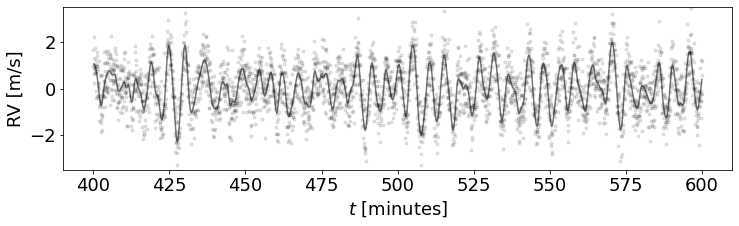

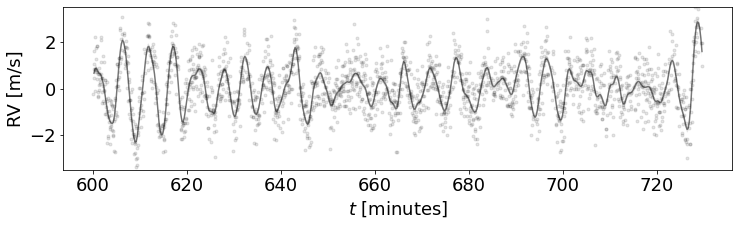

In [81]:
for i in range(4):
    fig = plt.figure(figsize=(12, 3))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    # plt.title(str(date)[:10])
    # plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)

    plt.plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.5)
    plt.fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.1,
                     edgecolor="none")
    plt.xlabel('$t$ [minutes]')
    plt.ylabel('RV [m/s]')
    plt.ylim([-3.5, 3.5])
    plt.show()

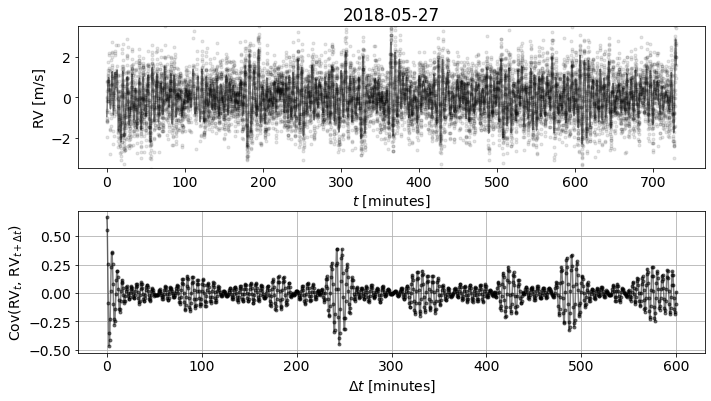

In [84]:
%matplotlib inline
from scipy.signal import hilbert, chirp

def moving_ave(t, y, width=2):
    w_aves = []
    for t_i in t:
        weights = stats.norm.pdf(t, t_i, width)
        # weights = np.multiply(abs(array_x-t_i)<width, 1) 
        w_ave, _ = weighted_avg_and_std(y, weights)
        w_aves.append(w_ave)
        # w_stds.append(w_std)
    return np.array(w_aves)
        

start_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 7, 22)
end_date = datetime(2018, 5, 27)

# beats_widths = np.array([])
beats_heights = np.array([])
beats_centres = np.array([])
days = np.array([])

beats_widths_by_day = []
beats_heights_by_day = []
beats_centres_by_day = []

Day = []
Amplitude_envelopes = np.array([])
Cov_XYs = np.array([])

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    delta_t = max(t) - min(t)
    
    if delta_t>600:
    
        y = rv[idx_bjd]
        yerr = np.ones(len(t))*0.5
        gp = GP_fit_p1(t, y, yerr, p=5.37)

        fig = plt.figure(figsize=(12, 6))
        plt.subplots_adjust(right=0.85, hspace=0.3)
        plt.rcParams.update({'font.size': 14})
        
        ## Upper panel
        fig.add_subplot(211)
        plt.title(str(date)[:10])
        plt.plot(t, y, 'k.', alpha=0.1)
        x = np.linspace(min(t), max(t), 3000)
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)        
        plt.plot(x, pred_mean, color='k', alpha=0.5)
        plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                         edgecolor="none")
        plt.xlabel('$t$ [minutes]')
        plt.ylabel('RV [m/s]')
        # plt.xlim([-10, 760])
        plt.ylim([-3.5, 3.5])
    
        ## Lower panel 
        Delta_t = np.linspace(0, 600, 1201)
        cov_XY = []

        # new

        for delta_t in Delta_t:
            t_cov = np.linspace(0, max(t)-delta_t, int(max(t)-delta_t)+1)
            X, _ = gp.predict(y, t_cov, return_var=False)
            Y, _ = gp.predict(y, t_cov+delta_t, return_var=False)
            cov_XY.append(cov(X, Y))
        # new

        # analytic_signal = hilbert(cov_XY)
        # amplitude_envelope = np.abs(analytic_signal)
        # amplitude_envelope = moving_ave(Delta_t, amplitude_envelope, width=5) 
        # peaks1, prop1 = find_peaks(amplitude_envelope, height=0.01)  # local max 
        # peaks2, prop2 = find_peaks(-amplitude_envelope, height=-10) # local min 
        if len(Amplitude_envelopes) == 0:
            # Amplitude_envelopes = amplitude_envelope
            Cov_XYs = cov_XY
        else:
            # Amplitude_envelopes = np.vstack((Amplitude_envelopes, amplitude_envelope))
            Cov_XYs = np.vstack((Cov_XYs, cov_XY))

        fig.add_subplot(212)
        plt.plot(Delta_t, cov_XY, 'k.-', alpha=0.5)
        # plt.plot(Delta_t, amplitude_envelope, 'm', lw=3, alpha=0.4)
        # plt.plot(Delta_t, -amplitude_envelope, 'm', lw=3, alpha=0.4)
        # plt.plot(Delta_t[peaks1], prop1['peak_heights'], 'o', color='green', markersize=8)
        # plt.plot(Delta_t[peaks1], -prop1['peak_heights'], 'o', color='green', markersize=8)
        # plt.plot(Delta_t[peaks2], prop2['peak_heights'], 'o', color='red', markersize=8)
        # plt.plot(Delta_t[peaks2], -prop2['peak_heights'], 'o', color='red', markersize=8)    
        plt.xlabel(r'$\Delta t$ [minutes]')
        plt.ylabel(r'Cov(RV$_t$, RV$_{t+\Delta t}$)')
        plt.grid()    

        # plt.savefig('./SONG/GP_RV_' + str(date)[:10] + '.png', dpi=600)
        plt.show()



        if 0:
            if len(prop1['peak_heights']) == len(np.diff(Delta_t[peaks2])):
                beats_heights = np.hstack((beats_heights, prop1['peak_heights']))
                beats_widths = np.hstack((beats_widths, np.diff(Delta_t[peaks2])))
                beats_centres = np.hstack((beats_centres, Delta_t[peaks1]))

            if len(prop1['peak_heights']) == (len(np.diff(Delta_t[peaks2]))+1):
                beats_heights = np.hstack((beats_heights, prop1['peak_heights'][:-1]))
                beats_widths = np.hstack((beats_widths, np.diff(Delta_t[peaks2])))    
                beats_centres = np.hstack((beats_centres, Delta_t[peaks1][:-1]))    

        if 0: # just getting the envelope peak centre position 
            beats_centres = np.hstack((beats_centres, Delta_t[peaks1]))
            beats_heights = np.hstack((beats_heights, prop1['peak_heights']))
            days = np.hstack((  days, T1*np.ones( len(Delta_t[peaks1]) )   ))
            beats_centres_by_day.append(Delta_t[peaks1])
            beats_heights_by_day.append(prop1['peak_heights'])
            Day.append(T1)


In [72]:
1/(3100*1e-6)/60

5.376344086021505